In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

<h1> Basics</h1>

$
    g(x, y)= 
\begin{cases}
    1,& \text{if } f(x, y) > T\\
    0,& \text{if} f(x,y) \leq T\\
\end{cases}
$

<br>

This means that if the pixel intensity is greater than a threshold, we make it foreground pixel (hence we color it white), else we make it a background pixel ( we color it black). This results in a binary image, which is created from the grayscale representation of the image.

<br>

<h2> Types of thresholding </h2>

<ul> 
    <li><b>Global Thresholding :</b> If T(threshold value) remains constant over the entire image and does not change, the thresholding operation is called global thresholding. </li>
    <li><b>Variable Thresholding :</b> If T value changes, we call it variable thresolding.
        <ul>
            <li><b> Local/Regional Thresholding : </b> If the threshold value at any pixel (x,y) depends upon the properties of the neighbourhood pixels (eg. average intensity in neighbourhood of(x,y), we call that variable method local thresholding.
            <li><b>Dynamic Thresholding :</b> If the threshold value at any pixel depends upon the spacial co-ordinates of the pixel (x,y), we call that variable method dynamic thresholding.</li>
        </ul>
    </li>

</ul>

<h2> Example of basic global thresholding using intensity histogram </h2>

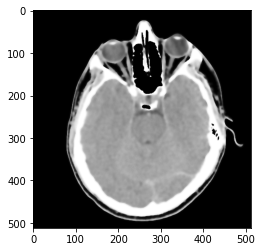

In [2]:
#load image and convert into grayscale
image = cv2.cvtColor(cv2.imread("../images/brain.tif"), cv2.COLOR_BGR2GRAY)
image = cv2.bilateralFilter(image,9,75,75)
plt.imshow(image, cmap = 'gray')

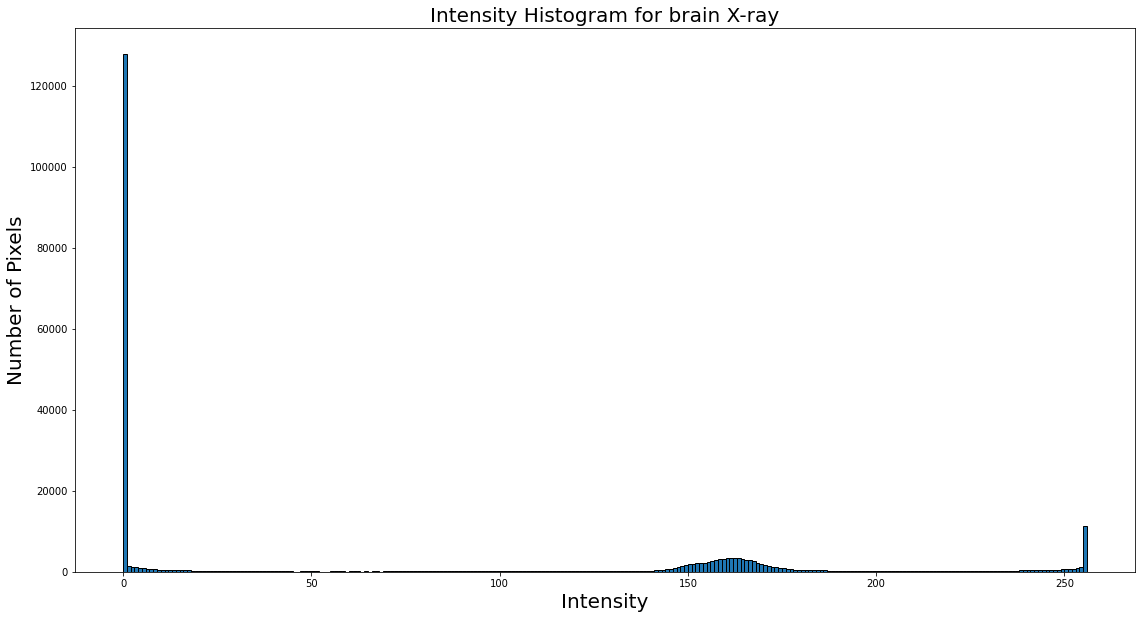

In [3]:
#calculate histogram parameters
plt.figure(figsize = (19, 10))
plt.title("Intensity Histogram for brain X-ray", fontsize = 20)
plt.xlabel("Intensity", fontsize = 20)
plt.ylabel("Number of Pixels", fontsize = 20)
histo,bins,_=plt.hist(image.flat,bins=256,range=(0, 256),ec='black')
plt.show()


<p>The lower 0 pixels are background. The upper 255 intensity pixels are the white portion in image. The gray pixels are mainly between 100-220. We will segment them out</p>

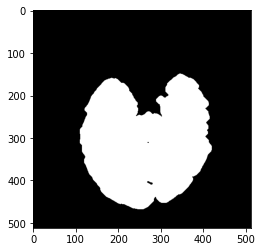

In [4]:
def segment_image(image, lower_bound, upper_bound):
    
    resImg = []
    
    for pixel in image.reshape(-1):
        
        if pixel >= lower_bound and pixel <= upper_bound :
            resImg.append(255)
            continue
        resImg.append(0)
    
    
    return np.array(resImg, dtype = np.uint8).reshape(image.shape)


seg_img = segment_image(image, 140, 180)
# seg_img = cv2.erode(seg_img,kernel = np.ones((3, 3), dtype = np.float32),iterations = 2)
seg_img = cv2.morphologyEx(seg_img, cv2.MORPH_OPEN, kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3)), iterations = 6)

seg_img = cv2.dilate(seg_img, kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5)), iterations = 2)
# seg_img = cv2.erode(seg_img,kernel = np.ones((3, 3), dtype = np.float32),iterations = 3)


seg_img = cv2.medianBlur(src = seg_img, dst = seg_img, ksize =  3)
plt.imshow(seg_img, cmap = "gray")
            

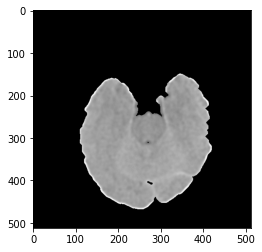

In [5]:
#mask this to original image
res = cv2.bitwise_and(image, image,  mask = seg_img)

plt.imshow(res, cmap = 'gray')

<p> So, by using thresholding and some morphological operations, we segmented out the brain region from the image</p>

<h1> Effect of noise on thresholding </h1>

<p> Let's first load a noiseless image </p>

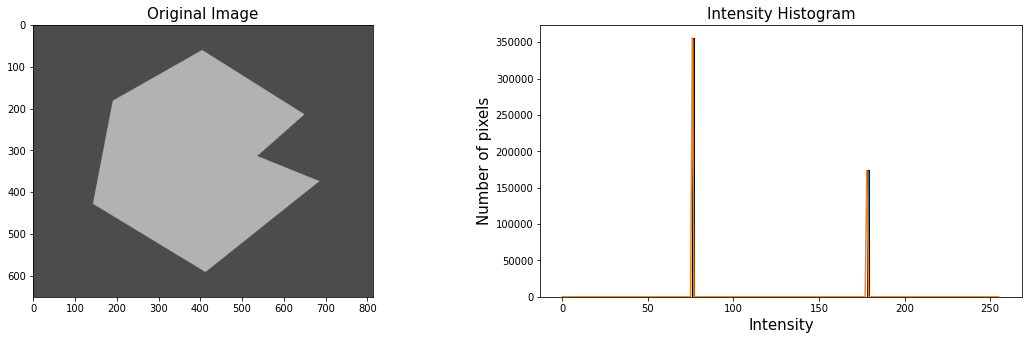

In [6]:
image = cv2.imread("../images/septagon.tif", cv2.IMREAD_GRAYSCALE)

fig, axs = plt.subplots(1, 2)
fig.set_figheight(5)
fig.set_figwidth(19)
histo,bins,_=plt.hist(image.flat,bins=256,range=(0, 256),ec='black')

axs[0].imshow(image, cmap = 'gray', vmin=0, vmax=255)
axs[0].set_title("Original Image", fontsize = 15)


axs[1].plot(histo)
axs[1].set_title("Intensity Histogram", fontsize = 15)
axs[1].set_xlabel("Intensity", fontsize = 15)
axs[1].set_ylabel("Number of pixels",fontsize = 15)

plt.show()


<p> In this case, it is easy to threshold image by taking any value between the two peaks </p>

<p> Let's now add some gaussian noise with zero mean and 10 std deviation to the image. We will draw these samples from a standard normal distribution.</p>

Text(0, 0.5, 'Number of pixels')

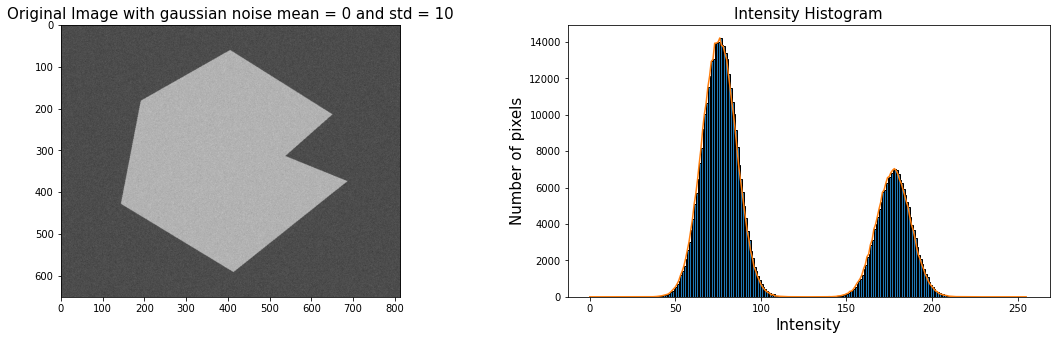

In [7]:
noise  = np.random.normal(loc = 0, scale = 10.0 , size = image.shape)
noise_img1 = image + noise


fig, axs = plt.subplots(1, 2)
fig.set_figheight(5)
fig.set_figwidth(19)
histo,bins,_=plt.hist(noise_img1.flat,bins=256,range=(0, 256),ec='black')

axs[0].imshow(noise_img1, cmap = 'gray', vmin = 0, vmax = 255)
axs[0].set_title("Original Image with gaussian noise mean = 0 and std = 10", fontsize = 15)

axs[1].plot(histo)
axs[1].set_title("Intensity Histogram", fontsize = 15)
axs[1].set_xlabel("Intensity", fontsize = 15)
axs[1].set_ylabel("Number of pixels",fontsize = 15)



<p> It's still easy to segment if less noise is present. We can choose any value between 100 and 150 as threshold</p>

<p>Let's increase the std dev of the gaussian noise.</p>

Text(0, 0.5, 'Number of pixels')

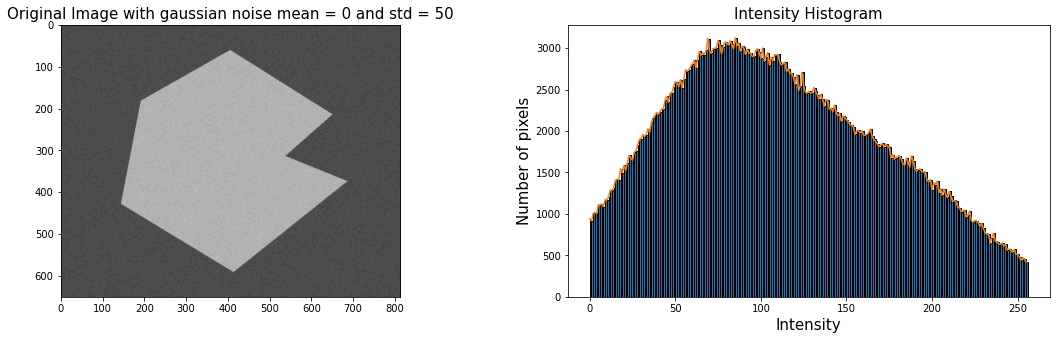

In [8]:
noise  = np.random.normal(loc = 0, scale = 50.0 , size = image.shape)
noise_img2 = cv2.add(image, noise, dtype = cv2.CV_64F)


fig, axs = plt.subplots(1, 2)
fig.set_figheight(5)
fig.set_figwidth(19)
histo,bins,_=plt.hist(noise_img2.flat,bins=256,range=(0, 256),ec='black')

axs[0].imshow(noise_img1, cmap = 'gray', vmin = 0, vmax = 255)
axs[0].set_title("Original Image with gaussian noise mean = 0 and std = 50", fontsize = 15)

axs[1].plot(histo)
axs[1].set_title("Intensity Histogram", fontsize = 15)
axs[1].set_xlabel("Intensity", fontsize = 15)
axs[1].set_ylabel("Number of pixels",fontsize = 15)


<p> Now, it is very difficult to come out with a threshold value. We have to remove noise before thresholding. </p>

<h1> Effect of Illumination and Reflectance on thresholding </h1>

<p> We will use the first noisy image for this task</p>

Text(0, 0.5, 'Number of pixels')

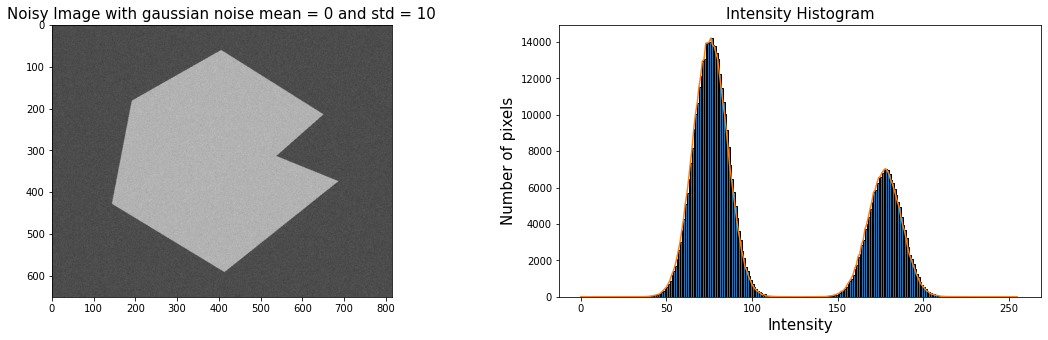

In [9]:
fig, axs = plt.subplots(1, 2)
fig.set_figheight(5)
fig.set_figwidth(19)
histo,bins,_=plt.hist(noise_img1.flat,bins=256,range=(0, 256),ec='black')

axs[0].imshow(noise_img1, cmap = 'gray', vmin = 0, vmax = 255)
axs[0].set_title("Noisy Image with gaussian noise mean = 0 and std = 10", fontsize = 15)

axs[1].plot(histo)
axs[1].set_title("Intensity Histogram", fontsize = 15)
axs[1].set_xlabel("Intensity", fontsize = 15)
axs[1].set_ylabel("Number of pixels",fontsize = 15)


<p> Creating an intensity ramp. It's a non uniform intensity function</p>

Text(0, 0.5, 'Number of pixels')

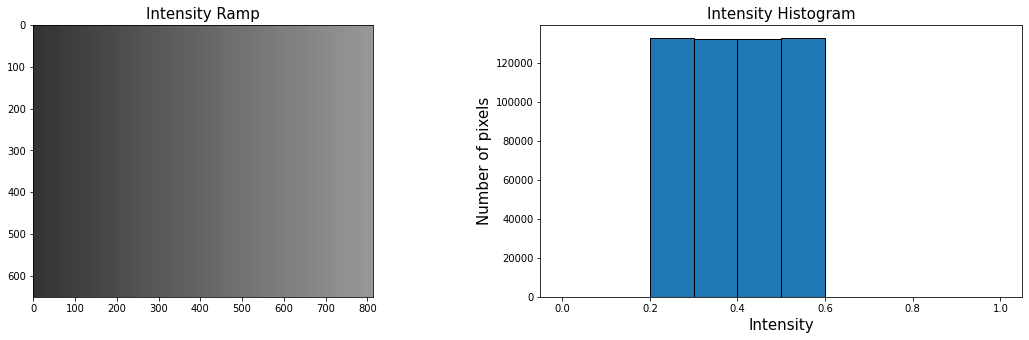

In [10]:
intensity_ramp = np.tile(np.linspace(0.2, 0.6, image.shape[1]), (image.shape[0], 1))

fig, axs = plt.subplots(1, 2)
fig.set_figheight(5)
fig.set_figwidth(19)

im_ramp = np.array(intensity_ramp*255, dtype = np.uint8)
axs[0].imshow(im_ramp, cmap = 'gray', vmin = 0, vmax = 255)
axs[0].set_title("Intensity Ramp", fontsize = 15)

histo,bins,_=plt.hist(intensity_ramp.flat,bins=10,range=(0, 1),ec='black')
axs[1].set_title("Intensity Histogram", fontsize = 15)
axs[1].set_xlabel("Intensity", fontsize = 15)
axs[1].set_ylabel("Number of pixels",fontsize = 15)



<p> The noisy image is still separable. Multiplying the image with the above uniform distribution</p>

Text(0, 0.5, 'Number of pixels')

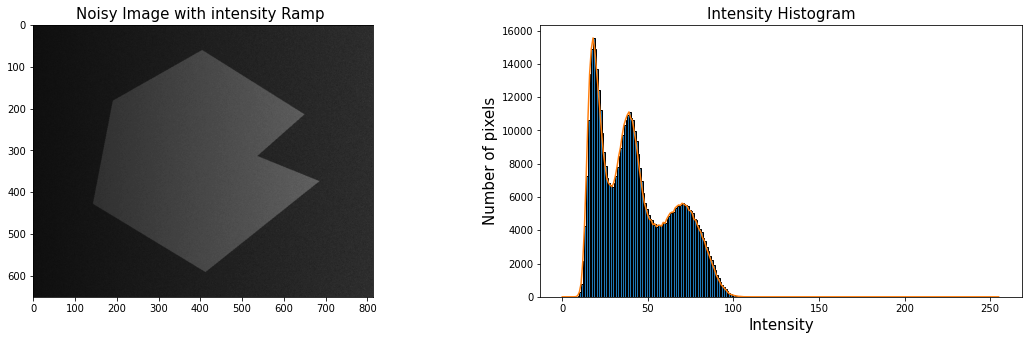

In [11]:
noise_img3 = noise_img1 * intensity_ramp


fig, axs = plt.subplots(1, 2)
fig.set_figheight(5)
fig.set_figwidth(19)
histo,bins,_=plt.hist(noise_img3.flat,bins=256,range=(0, 256),ec='black')

axs[0].imshow(noise_img3, cmap = 'gray', vmin = 0, vmax = 255)
axs[0].set_title("Noisy Image with intensity Ramp ", fontsize = 15)

axs[1].plot(histo)
axs[1].set_title("Intensity Histogram", fontsize = 15)
axs[1].set_xlabel("Intensity", fontsize = 15)
axs[1].set_ylabel("Number of pixels",fontsize = 15)


<p> Now, it is very difficult to look for a threshold value just by visualization. </p>

<h2> Remedies</h2>
<p> 
<ul>
    <li>We can multiply the image with reverse of the intensity ramp matrix. Matrix inverse logic(if it exists)</li>
    <li>Second approach involves correcting global shading pattern via top-hat transformation.(dunno about this)</li>
    <li>We can use variable thresholding.</li>

</ul>
</p>

<h2> References </h2>

[1] Gonzalez, R. C., & Woods, R. E. (2002). Digital image processing.<br>
[2] Bradski, G. (2000). The OpenCV Library. Dr. Dobb&#x27;s Journal of Software Tools.<br>
[3] https://homepages.inf.ed.ac.uk/rbf/HIPR2/pixadd.htm <br>
[4] https://stackoverflow.com/questions/22937589/how-to-add-noise-gaussian-salt-and-pepper-etc-to-image-in-python-with-opencv